## Logistic Regression via Newton's Method

* Newton's Method Functions:  
     - **logfunc(x)**: finds the logistic function  $$f(x) = \frac{1}{1+e^{-\beta^Tx}}$$
     - **newton_method_lrstep(beta0,y,X)**: Updates Newton's Method, $$\beta^{(t+1)} = \beta^{(t)} + H^{-1}\nabla{l(\beta)}$$  where $l(\beta)$ is the log-likelihood of $\beta$ for a Logistic Regression  
     - **tolerance_check(beta0,beta,eps)**: Checks if it converges to a set threshold, $$|\beta^{(t)}-\beta^{t+1}|<\epsilon$$
     - **newton_method_logreg(beta0,y,X,eps)**: Newton's Method for Logistic Regression

In [1]:
import numpy as np
import scipy.linalg as linalg


def logfun(x): # logistic function
    p = 1/(1+np.exp(-x)) # probability
    return p

def newton_method_lrstep(beta0,y,X, method):
    betaX = np.dot(X,beta0) # beta*X
    yx = logfun(betaX) # y_hat
    y_hat = np.array(yx,ndmin=2) # converts to y_hat array
    gradient = np.dot(X.T, (y-y_hat)) # gradient

    ny_hat = 1-y_hat
    d = np.dot(y_hat,ny_hat.T)
    diag = np.diag(d)
    d = np.diag(diag)
    hessian = X.to_numpy().T.dot(d).dot(X.to_numpy()) # hessian matrix
    n = hessian.shape[1]
    if method == "LU":
        hessian_inv = np.linalg.inv(hessian)
    elif method == "QR":
        Q,R = np.linalg.qr(hessian)
        Rinv = linalg.solve_triangular(R,np.identity(n))
        hessian_inv = np.dot(Rinv,Q.T)
    else:
        c, low = linalg.cho_factor(hessian)
        hessian_inv = linalg.cho_solve((c,low),np.identity(n))

    gd = np.dot(hessian_inv,gradient) # finds the step direction

    beta = beta0 + gd # updates coefficients

    return beta

def tolerance_check(beta0, beta, eps):
    diff = np.abs(beta0-beta) # norm 
    if np.any(diff>eps): # if norm crosses threshold
        return False
    else:
        return True
    
def newton_method_logreg(beta0, y, X,eps,method):
    iterations = 0 # initial iterations
    converge = False # sets converge to false
    while not converge: # while converge is false
        beta = newton_method_lrstep(beta0,y,X,method) # finds new beta
        converge = tolerance_check(beta0,beta,eps) # checks convergence
        beta0 = beta # updates beta
        iterations +=1 # updates iterations
        print ("Iteration: {}".format(iterations))
    return beta

**Split Dataset**  

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

dropout = pd.read_csv("../Datasets/dropoutlr.csv", sep=",")
dropout = dropout.iloc[: , 1:]
X = dropout.drop(['Target'],axis=1)
y = dropout[["Target"]]

X_train,x_test,y_train, y_test = train_test_split(X,y ,random_state=100, test_size=0.20, shuffle=True)

**Initial Test**

In [30]:
import numpy as np

n = X.shape[1]
beta0 = np.zeros((n,1))
eps = 10**(-3)
beta = newton_method_logreg(beta0,y_train,X_train,eps,method="Chol")
beta

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


array([[ 1.95649348e-01],
       [-3.85256218e-03],
       [-9.77057379e-02],
       [-3.03665487e-04],
       [-1.08256683e-01],
       [ 1.19632110e-02],
       [-4.51657753e-03],
       [-3.81610647e-02],
       [-1.47990980e-02],
       [ 8.94216282e-03],
       [ 1.44232567e-02],
       [-5.45289245e-03],
       [ 7.03087472e-03],
       [-2.53808171e-01],
       [-4.50971225e-01],
       [-4.53833628e-01],
       [ 2.23775262e+00],
       [-1.65854305e-01],
       [ 6.21195201e-01],
       [-4.23513861e-02],
       [ 2.28528835e+00],
       [-1.05114140e-01],
       [ 1.89446829e-01],
       [-4.75809816e-02],
       [-4.12300546e-01],
       [ 5.17470819e-01],
       [ 1.07938574e-01],
       [-6.70271680e-02],
       [-2.04644295e-02],
       [-3.42811103e-03]])

**Logistic Regression Comparison**

In [4]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.324004
         Iterations 7
                                   Results: Logit
Model:                      Logit                  Pseudo R-squared:       0.487    
Dependent Variable:         Target                 AIC:                    2353.3020
Date:                       2023-03-23 08:39       BIC:                    2538.4500
No. Observations:           3539                   Log-Likelihood:         -1146.7  
Df Model:                   29                     LL-Null:                -2236.6  
Df Residuals:               3509                   LLR p-value:            0.0000   
Converged:                  1.0000                 Scale:                  1.0000   
No. Iterations:             7.0000                                                  
------------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975

**Testing**  
Taken from online resource

In [3]:
def predict_lr(X,y,beta):
    xbeta = np.dot(X,beta)
    predict = np.array(logfun(xbeta))
    threshold = 0.5*np.ones((predict.shape[0],1))
    pred_class = np.greater(predict,threshold)
    accuracy = np.count_nonzero(np.equal(pred_class, y))/pred_class.shape[0]
    return accuracy

In [6]:
acc, predict = predict_lr(x_test,y_test,beta)
acc

0.8745762711864407

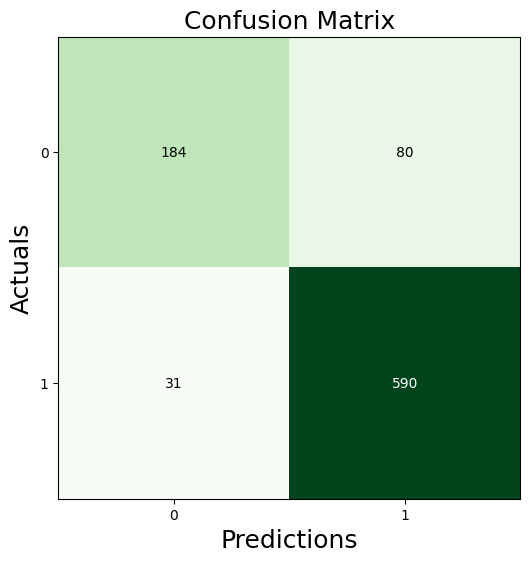

In [64]:
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

conf_matrix = metrics.confusion_matrix(y_test, predict)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

**Data Analysis Study**

True Dataset

In [32]:
import time

dropout = pd.read_csv("../Datasets/schooldropout.csv", sep=";")
dropout['Target'].replace(['Dropout', 'Graduate',"Enrolled"],[0, 1,1], inplace=True)

X = dropout.drop(['Target'],axis=1)
y = dropout[["Target"]]

accuracy = []
timeLU = []
timeQR = []
timeChol = []

for i in range(100):
    X_train,x_test,y_train, y_test = train_test_split(X,y ,random_state = 10+i, test_size=0.20, shuffle=True)
    n = X.shape[1]
    beta0 = np.zeros((n,1))
    eps = 10**(-3)

    start_timeLU = time.time()
    temp = newton_method_logreg(beta0,y_train,X_train,eps,method="LU")
    end_timeLU = time.time()
    timediffLU = end_timeLU-start_timeLU
    timeLU.append(timediffLU)

    start_timeQR = time.time()
    temp = newton_method_logreg(beta0,y_train,X_train,eps,method="QR")
    end_timeQR = time.time()
    timediffQR = end_timeQR-start_timeQR
    timeQR.append(timediffQR)

    start_timeChol = time.time()
    temp = newton_method_logreg(beta0,y_train,X_train,eps,method="Chol")
    end_timeChol = time.time()
    timediffChol = end_timeChol-start_timeChol
    timeChol.append(timediffChol)

    acc = predict_lr(x_test,y_test,temp)
    accuracy.append(acc)
    

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5

KeyboardInterrupt: 

In [71]:
np.mean(accuracy)
np.var(accuracy)

7.843608158575134e-05

Simulated Study

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

def sim_study(n, d, p=False):
    if p == True:
        beta = np.random.uniform(-10,10,d)
        cat = pd.DataFrame()
        linpred = np.matrix(np.zeros(n))
        for i in range(d):
            var = np.random.uniform(0,10,n)
            var = pd.DataFrame(var)
            cat = pd.concat([cat,var], axis=1)
        for i in range(d):
            x_i=cat.iloc[:,i:i+1].values
            x_i = np.matrix(x_i)
            beta_i = beta[[i]]
            linpred = linpred + x_i*beta_i
        prob = (np.exp(linpred))/(1+np.exp(linpred))
        target = np.random.binomial(1,p=prob[0]).T
        target = pd.DataFrame(target)
    else:
        cat,target = make_classification(n,d,n_classes=2)
    data = pd.concat([cat,target],axis =1)
    return data

In [9]:
X,y = make_classification(n_samples=10000, n_features=36, n_informative=36, 
                    n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2,
                          class_sep=1.5)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
beta0 = np.zeros((36,1))
eps = 10**(-3)
    

In [10]:
import time
accuracy = []
timeLU = []
timeQR = []
timeChol = []
for i in range(100):
    X_train,x_test,y_train, y_test = train_test_split(X,y ,random_state = 10+i, test_size=0.20, shuffle=True)
    beta0 = np.zeros((36,1))
    eps = 10**(-3)

    start_timeLU = time.time()
    temp = newton_method_logreg(beta0,y_train,X_train,eps,method="LU")
    end_timeLU = time.time()
    timediffLU = end_timeLU-start_timeLU
    timeLU.append(timediffLU)

    start_timeQR = time.time()
    temp = newton_method_logreg(beta0,y_train,X_train,eps,method="QR")
    end_timeQR = time.time()
    timediffQR = end_timeQR-start_timeQR
    timeQR.append(timediffQR)

    start_timeChol = time.time()
    temp = newton_method_logreg(beta0,y_train,X_train,eps,method="Chol")
    end_timeChol = time.time()
    timediffChol = end_timeChol-start_timeChol
    timeChol.append(timediffChol)

    acc = predict_lr(x_test,y_test,temp)
    accuracy.append(acc)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7

In [ ]:
tena = np.mean(accuracy)
tenva = np.var(accuracy)
tenlu = np.mean(timediffLU)
tenvlu = np.var(timediffLU)
tenqr = np.mean(timediffQR)
tenvqr = np.var(timediffQR)
tenchol = np.mean(timediffChol)
tenvchol = np.mean(timediffChol)
print(tena,tenva,tenlu,tenvlu,tenqr,tenvqr,tenchol,tenvchol)


In [6]:
import time
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

def predict_lr(X,y,beta):
    xbeta = np.dot(X,beta)
    predict = np.array(logfun(xbeta))
    threshold = 0.5*np.ones((predict.shape[0],1))
    pred_class = np.greater(predict,threshold)
    accuracy = np.count_nonzero(np.equal(pred_class, y))/pred_class.shape[0]
    return accuracy

X,y = make_classification(n_samples=50000, n_features=36, n_informative=36, 
                    n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2,
                          class_sep=1.5)
X = pd.DataFrame(X)
y = pd.DataFrame(y)
beta0 = np.zeros((36,1))
eps = 10**(-3)
accuracy = []
timeLU = []
timeQR = []
timeChol = []
for i in range(1):
    X_train,x_test,y_train, y_test = train_test_split(X,y ,random_state = 10+i, test_size=0.20, shuffle=True)
    beta0 = np.zeros((36,1))
    eps = 10**(-3)

    start_timeLU = time.time()
    temp = newton_method_logreg(beta0,y_train,X_train,eps,method="LU")
    end_timeLU = time.time()
    timediffLU = end_timeLU-start_timeLU
    timeLU.append(timediffLU)

    start_timeQR = time.time()
    temp = newton_method_logreg(beta0,y_train,X_train,eps,method="QR")
    end_timeQR = time.time()
    timediffQR = end_timeQR-start_timeQR
    timeQR.append(timediffQR)

    start_timeChol = time.time()
    temp = newton_method_logreg(beta0,y_train,X_train,eps,method="Chol")
    end_timeChol = time.time()
    timediffChol = end_timeChol-start_timeChol
    timeChol.append(timediffChol)

    acc = predict_lr(x_test,y_test,temp)
    accuracy.append(acc)
    
print(timeLU,timeChol,timeQR,accuracy)

Iteration: 1
